In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import glob
import os
import xgboost as xgb
import dask.array as da
import dask.dataframe as dd
from sklearn.metrics import accuracy_score, confusion_matrix

stations_info = pd.read_csv('Informacio_Estacions_Bicing_2025.csv')
stations_info_2 = pd.read_csv('stations_with_distance_info.csv')
calendar = pd.read_csv('Calendar.csv')

stations_info = stations_info.merge(
    stations_info_2[['station_id','nearest_station_id','nearest_station_distance','stations_within_100m','stations_within_300m','stations_within_500m']],  # Seleccionamos la columna específica de df_extra
    on='station_id',  # Columna común para la fusión
    how='left'  # Realizamos el left join
)

In [7]:
stations_info.head()

,station_id,name,physical_configuration,lat,lon,altitude,address,cross_street,post_code,capacity,...,short_name,nearby_distance,_ride_code_support,rental_uris,is_valet_station,nearest_station_id,nearest_station_distance,stations_within_100m,stations_within_300m,stations_within_500m
0,1,"GRAN VIA CORTS CATALANES, 760",ELECTRICBIKESTATION,41.397978,2.180107,16.0,"GRAN VIA CORTS CATALANES, 760",02-Eixample/05-el Fort Pienc,8013.0,46,...,1,1000.0,True,NaN,NaN,119,244.848175,0,4,10
1,2,"C/ ROGER DE FLOR, 126",ELECTRICBIKESTATION,41.395488,2.177198,17.0,"C/ ROGER DE FLOR, 126",02-Eixample/05-el Fort Pienc,8013.0,29,...,2,1000.0,True,NaN,NaN,387,130.334310,0,4,10
2,3,"C/ NÀPOLS, 82",ELECTRICBIKESTATION,41.394156,2.181331,11.0,"C/ NÀPOLS, 82",02-Eixample/05-el Fort Pienc,8013.0,27,...,3,1000.0,True,NaN,NaN,4,93.367414,1,2,12
3,4,"C/ RIBES, 13",ELECTRICBIKESTATION,41.393317,2.181248,8.0,"C/ RIBES, 13",02-Eixample/05-el Fort Pienc,8013.0,21,...,4,1000.0,True,NaN,NaN,3,93.367414,1,5,11
4,5,"PG. LLUIS COMPANYS, 11 (ARC TRIOMF)",ELECTRICBIKESTATION,41.391103,2.180176,7.0,"PG. LLUIS COMPANYS, 11 (ARC TRIOMF)","01-CiutatVella/04-Sant Pere, Santa Caterina i ...",8018.0,39,...,5,1000.0,True,NaN,NaN,418,6.943977,3,5,12


In [9]:
stations_info.columns

Index(['station_id', 'name', 'physical_configuration', 'lat', 'lon',
       'altitude', 'address', 'cross_street', 'post_code', 'capacity',
       'is_charging_station', 'short_name', 'nearby_distance',
       '_ride_code_support', 'rental_uris', 'is_valet_station',
       'nearest_station_id', 'nearest_station_distance',
       'stations_within_100m', 'stations_within_300m', 'stations_within_500m'],
      dtype='object')

In [9]:
calendar.head()

,date,week_type,local_holiday,special_event,affected_status
0,2020-01-01,Weekday,True,False,Local Holiday
1,2020-01-02,Weekday,False,True,Special Event
2,2020-01-03,Weekday,False,False,NaN
3,2020-01-04,Weekend,False,False,Weekend
4,2020-01-05,Weekend,False,False,Weekend


In [13]:
df_datos_bikes = dd.read_csv(r"C:\Users\usuario\Documents\Python Scripts\Proyecto_modelo_submission\datos\*.csv", dtype={'last_reported': 'float64','station_id':'float64','num_docks_available':'float64','is_returning':'float64','ttl':'float64'},assume_missing=True)


In [15]:
df_datos_bikes.head()

,station_id,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,last_reported,is_charging_station,status,is_installed,is_renting,is_returning,traffic,last_updated,ttl
0,1.0,18.0,12.0,6.0,28.0,1.640992e+09,True,IN_SERVICE,1.0,1.0,1.0,NaN,1.640992e+09,18.0
1,2.0,18.0,15.0,3.0,11.0,1.640991e+09,True,IN_SERVICE,1.0,1.0,1.0,NaN,1.640992e+09,18.0
2,3.0,12.0,12.0,0.0,15.0,1.640992e+09,True,IN_SERVICE,1.0,1.0,1.0,NaN,1.640992e+09,18.0
3,4.0,2.0,1.0,1.0,18.0,1.640991e+09,True,IN_SERVICE,1.0,1.0,1.0,NaN,1.640992e+09,18.0
4,5.0,6.0,4.0,2.0,33.0,1.640991e+09,True,IN_SERVICE,1.0,1.0,1.0,NaN,1.640992e+09,18.0


In [17]:
df_datos_bikes.tail()

,station_id,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,last_reported,is_charging_station,status,is_installed,is_renting,is_returning,traffic,last_updated,ttl
515.0,12.0,9.0,3.0,12.0,1.717194e+09,1.0,True,1.0,1.0,1.0,NaN,1.717194e+09,0.0,NaN
516.0,7.0,5.0,2.0,14.0,1.717194e+09,1.0,True,1.0,1.0,1.0,NaN,1.717194e+09,0.0,NaN
517.0,6.0,3.0,3.0,14.0,1.717193e+09,1.0,True,1.0,1.0,1.0,NaN,1.717194e+09,0.0,NaN
518.0,2.0,1.0,1.0,23.0,1.717194e+09,1.0,True,1.0,1.0,1.0,NaN,1.717194e+09,0.0,NaN
519.0,11.0,1.0,10.0,13.0,1.717194e+09,1.0,True,1.0,1.0,1.0,NaN,1.717194e+09,0.0,NaN


In [15]:
#Transformamos en un formato de hora legible
df_datos_bikes["last_reported"] = dd.to_datetime(df_datos_bikes["last_reported"], unit='s')


In [17]:
#Descomponemos el Datatime (last_reported)
df_datos_bikes["year"] = df_datos_bikes["last_reported"].dt.year
df_datos_bikes["month"] = df_datos_bikes["last_reported"].dt.month
df_datos_bikes["day"] = df_datos_bikes["last_reported"].dt.day
df_datos_bikes["hour"] = df_datos_bikes["last_reported"].dt.hour

In [19]:
df_datos_bikes.dropna(subset=['last_reported'])

,station_id,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,last_reported,is_charging_station,status,is_installed,is_renting,is_returning,traffic,last_updated,ttl,year,month,day,hour
npartitions=113,,,,,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,datetime64[ns],bool,string,float64,float64,float64,float64,float64,float64,int32,int32,int32,int32
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [21]:
df_final = df_datos_bikes.groupby(['station_id', 'year', 'month', 'day', 'hour'])[['num_docks_available','num_bikes_available']].median().round(2).reset_index()

In [27]:
#df_final.compute().head(50)

,station_id,year,month,day,hour,num_docks_available,num_bikes_available
0,27.0,1970.0,1.0,1.0,0.0,1.710843e+09,15.0
1,27.0,2021.0,12.0,31.0,22.0,1.800000e+01,3.0
2,27.0,2021.0,12.0,31.0,23.0,1.700000e+01,4.0
3,27.0,2022.0,1.0,1.0,0.0,2.000000e+01,1.0
4,27.0,2022.0,1.0,1.0,1.0,6.000000e+00,15.0
5,27.0,2022.0,1.0,1.0,2.0,6.000000e+00,15.0
6,27.0,2022.0,1.0,1.0,3.0,5.000000e+00,16.0
7,27.0,2022.0,1.0,1.0,4.0,6.000000e+00,15.0
8,27.0,2022.0,1.0,1.0,5.0,5.000000e+00,16.0
9,27.0,2022.0,1.0,1.0,6.0,5.000000e+00,16.0


In [23]:
import pandas as pd
# Asegurar que 'result' es un DataFrame de Pandas
if not isinstance(df_final, pd.DataFrame):
    df_final = df_final.compute()  # Convertir de Dask a Pandas si es necesario

In [25]:
import pandas as pd

# Configura la visualización de pandas para mostrar números con 2 decimales
pd.options.display.float_format = '{:,.4f}'.format

# Luego, realiza la operación de groupby y median
#df_final = df_datos_bikes.groupby(['station_id', 'year', 'month', 'day', 'hour'])[['num_docks_available', 'num_bikes_available']].median().reset_index()

# Redondea los resultados a 2 decimales si es necesario
df_final = df_final.round(4)

In [27]:
df_final.head()

,station_id,year,month,day,hour,num_docks_available,num_bikes_available
0,27.0000,"1,970.0000",1.0000,1.0000,0.0000,"1,710,843,108.0000",15.0000
1,27.0000,"2,021.0000",12.0000,31.0000,22.0000,18.0000,3.0000
2,27.0000,"2,021.0000",12.0000,31.0000,23.0000,17.0000,4.0000
3,27.0000,"2,022.0000",1.0000,1.0000,0.0000,20.0000,1.0000
4,27.0000,"2,022.0000",1.0000,1.0000,1.0000,6.0000,15.0000


In [29]:
df_final = df_final.loc[df_final['year'] != 1970]
#df_final = df_final.loc[df_final['year'] != 2021]
df_final[['station_id','year','month','day','hour']] = df_final[['station_id','year','month','day','hour']].astype(int)
df_final.year.unique()

array([2021, 2022, 2023, 2024])

In [ ]:
#stations_info = pd.read_csv('Informacio_Estacions_Bicing_2025.csv')

In [31]:
# Unir los DataFrames usando 'station_id' como clave
merged_df = pd.merge(df_final, stations_info, on="station_id", how="left")

# Mostrar las primeras filas del resultado
merged_df.head()

,station_id,year,month,day,hour,num_docks_available,num_bikes_available,name,physical_configuration,lat,...,short_name,nearby_distance,_ride_code_support,rental_uris,is_valet_station,nearest_station_id,nearest_station_distance,stations_within_100m,stations_within_300m,stations_within_500m
0,27,2021,12,31,22,18.0000,3.0000,"C/ PROVENÇA, 322",ELECTRICBIKESTATION,41.3968,...,27.0000,"1,000.0000",True,NaN,NaN,189.0000,132.2643,0.0000,2.0000,11.0000
1,27,2021,12,31,23,17.0000,4.0000,"C/ PROVENÇA, 322",ELECTRICBIKESTATION,41.3968,...,27.0000,"1,000.0000",True,NaN,NaN,189.0000,132.2643,0.0000,2.0000,11.0000
2,27,2022,1,1,0,20.0000,1.0000,"C/ PROVENÇA, 322",ELECTRICBIKESTATION,41.3968,...,27.0000,"1,000.0000",True,NaN,NaN,189.0000,132.2643,0.0000,2.0000,11.0000
3,27,2022,1,1,1,6.0000,15.0000,"C/ PROVENÇA, 322",ELECTRICBIKESTATION,41.3968,...,27.0000,"1,000.0000",True,NaN,NaN,189.0000,132.2643,0.0000,2.0000,11.0000
4,27,2022,1,1,2,6.0000,15.0000,"C/ PROVENÇA, 322",ELECTRICBIKESTATION,41.3968,...,27.0000,"1,000.0000",True,NaN,NaN,189.0000,132.2643,0.0000,2.0000,11.0000


In [33]:
# ants tenemos que cambiar capacity al max capacity de la estacion para que nos de como mucho 100% disponibilidad


merged_df['capacity'].fillna(merged_df['num_bikes_available'] + merged_df['num_docks_available'], inplace=True)

merged_df["num_docks_available_mod"]=merged_df[['num_docks_available', 'capacity']].min(axis=1)
# Agregar la columna "percentage_docks_available"
merged_df["percentage_docks_available"] = merged_df["num_docks_available_mod"] / merged_df["capacity"]

# Opcional: llenar valores NaN si hay estaciones sin capacidad registrada
merged_df["percentage_docks_available"].fillna(0, inplace=True)

C:\Users\usuario\AppData\Local\Temp\ipykernel_2932\1763875449.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df["percentage_docks_available"].fillna(0, inplace=True)


In [35]:
# Ordenar los datos correctamente antes de agrupar
df_prediction_task = merged_df.sort_values(
    by=['station_id', 'year', 'month', 'day', 'hour']
)

In [37]:
for i in range(1, 5):
    df_prediction_task = df_prediction_task.sort_values(by=['station_id','year', 'month', 'day', 'hour'])  # Ordena correctamente
    df_prediction_task[f'disponibilidad_porcentage_{i}h_antes'] = (
        df_prediction_task.groupby('station_id')['percentage_docks_available']
        .shift(i)  # Desplazamiento de i horas
        .fillna(0)  # Reemplaza NaN con 0
    )

In [38]:


# Ordenar cronológicamente y mostrar solo las columnas importantes
#df_prediction_task = df_prediction_task.sort_values(by=['year', 'month', 'day', 'hour'])

df_prediction_task[['station_id', 'year', 'month', 'day', 'hour', 
                   'percentage_docks_available', 
                   'disponibilidad_porcentage_1h_antes', 
                   'disponibilidad_porcentage_2h_antes', 
                   'disponibilidad_porcentage_3h_antes', 
                   'disponibilidad_porcentage_4h_antes']].head(50)  # Puedes ajustar el número de filas

,station_id,year,month,day,hour,percentage_docks_available,disponibilidad_porcentage_1h_antes,disponibilidad_porcentage_2h_antes,disponibilidad_porcentage_3h_antes,disponibilidad_porcentage_4h_antes
3204219,1,2021,12,31,22,0.6087,0.0000,0.0000,0.0000,0.0000
3204220,1,2021,12,31,23,0.6196,0.6087,0.0000,0.0000,0.0000
3204221,1,2022,1,1,0,0.6957,0.6196,0.6087,0.0000,0.0000
3204222,1,2022,1,1,1,0.7391,0.6957,0.6196,0.6087,0.0000
3204223,1,2022,1,1,2,0.7391,0.7391,0.6957,0.6196,0.6087
3204224,1,2022,1,1,3,0.7174,0.7391,0.7391,0.6957,0.6196
3204225,1,2022,1,1,4,0.7174,0.7174,0.7391,0.7391,0.6957
3204226,1,2022,1,1,5,0.6739,0.7174,0.7174,0.7391,0.7391
3204227,1,2022,1,1,6,0.6304,0.6739,0.7174,0.7174,0.7391
3204228,1,2022,1,1,7,0.6087,0.6304,0.6739,0.7174,0.7174


In [43]:
# elimino las 4 primeras filas, porque son primeros registros y tienen 0 en los antecedentes...

df_prediction_task = df_prediction_task.iloc[4:]

In [45]:
df_prediction_task.columns

Index(['station_id', 'year', 'month', 'day', 'hour', 'num_docks_available',
       'num_bikes_available', 'name', 'physical_configuration', 'lat', 'lon',
       'altitude', 'address', 'cross_street', 'post_code', 'capacity',
       'is_charging_station', 'short_name', 'nearby_distance',
       '_ride_code_support', 'rental_uris', 'is_valet_station',
       'nearest_station_id', 'nearest_station_distance',
       'stations_within_100m', 'stations_within_300m', 'stations_within_500m',
       'num_docks_available_mod', 'percentage_docks_available',
       'disponibilidad_porcentage_1h_antes',
       'disponibilidad_porcentage_2h_antes',
       'disponibilidad_porcentage_3h_antes',
       'disponibilidad_porcentage_4h_antes'],
      dtype='object')

In [169]:
df_prediction_task.head()

,station_id,year,month,day,hour,num_docks_available,num_bikes_available,name,physical_configuration,lat,...,num_docks_available_mod,percentage_docks_available,disponibilidad_porcentage_1h_antes,disponibilidad_porcentage_2h_antes,disponibilidad_porcentage_3h_antes,disponibilidad_porcentage_4h_antes,Date,special_event,is_weekend,is_holiday
0,1,2022,1,1,2,34.00,12.00,"GRAN VIA CORTS CATALANES, 760",ELECTRICBIKESTATION,41.40,...,34.00,0.74,0.74,0.70,0.62,0.61,2022-01-01,0,1,1
1,1,2022,1,1,3,33.00,13.00,"GRAN VIA CORTS CATALANES, 760",ELECTRICBIKESTATION,41.40,...,33.00,0.72,0.74,0.74,0.70,0.62,2022-01-01,0,1,1
2,1,2022,1,1,4,33.00,13.00,"GRAN VIA CORTS CATALANES, 760",ELECTRICBIKESTATION,41.40,...,33.00,0.72,0.72,0.74,0.74,0.70,2022-01-01,0,1,1
3,1,2022,1,1,5,31.00,15.00,"GRAN VIA CORTS CATALANES, 760",ELECTRICBIKESTATION,41.40,...,31.00,0.67,0.72,0.72,0.74,0.74,2022-01-01,0,1,1
4,1,2022,1,1,6,29.00,16.00,"GRAN VIA CORTS CATALANES, 760",ELECTRICBIKESTATION,41.40,...,29.00,0.63,0.67,0.72,0.72,0.74,2022-01-01,0,1,1


In [49]:
df_prediction_task['Date'] = pd.to_datetime(df_prediction_task[['year', 'month', 'day']].astype(str).agg('-'.join, axis=1))

In [50]:
calendar['Date'] = pd.to_datetime(calendar['date'], errors='coerce')

In [51]:
df_prediction_task = df_prediction_task.merge(
    calendar[['Date','special_event']],  # Seleccionamos la columna específica de df_extra
    on='Date',  # Columna común para la fusión
    how='left'  # Realizamos el left join
)

In [52]:
df_prediction_task['special_event'] = df_prediction_task['special_event'].replace({True: 1, False: 0})
df_prediction_task['is_charging_station'] = df_prediction_task['is_charging_station'].replace({True: 1, False: 0})


C:\Users\usuario\AppData\Local\Temp\ipykernel_2932\2428183260.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_prediction_task['special_event'] = df_prediction_task['special_event'].replace({True: 1, False: 0})
C:\Users\usuario\AppData\Local\Temp\ipykernel_2932\2428183260.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_prediction_task['is_charging_station'] = df_prediction_task['is_charging_station'].replace({True: 1, False: 0})


In [53]:
# Agregar la columna 'is_weekend' (1 si es sábado o domingo, 0 en otros casos)
df_prediction_task['is_weekend'] = df_prediction_task['Date'].dt.weekday.isin([5, 6]).astype(int)

In [54]:
import pandas as pd

# Lista de festivos (Año, Mes, Día, Nombre)
festivos_data = [
    (2022, 1, 1, "Año Nuevo"),
    (2022, 1, 6, "Reyes Magos"),
    (2022, 4, 15, "Viernes Santo"),
    (2022, 4, 18, "Lunes de Pascua"),
    (2022, 5, 1, "Día del Trabajador"),
    (2022, 6, 6, "Segunda Pascua (festivo local)"),
    (2022, 6, 24, "San Juan"),
    (2022, 8, 15, "La Asunción"),
    (2022, 9, 24, "La Mercè (festivo local)"),
    (2022, 10, 12, "Fiesta Nacional de España"),
    (2022, 11, 1, "Todos los Santos"),
    (2022, 12, 6, "Día de la Constitución"),
    (2022, 12, 8, "La Inmaculada"),
    (2022, 12, 25, "Navidad"),
    (2022, 12, 26, "San Esteban"),

    (2023, 1, 1, "Año Nuevo"),
    (2023, 1, 6, "Reyes Magos"),
    (2023, 4, 7, "Viernes Santo"),
    (2023, 4, 10, "Lunes de Pascua"),
    (2023, 5, 1, "Día del Trabajador"),
    (2023, 5, 29, "Segunda Pascua (festivo local)"),
    (2023, 6, 24, "San Juan"),
    (2023, 8, 15, "La Asunción"),
    (2023, 9, 11, "Diada de Cataluña"),
    (2023, 9, 25, "La Mercè (festivo local)"),
    (2023, 10, 12, "Fiesta Nacional de España"),
    (2023, 11, 1, "Todos los Santos"),
    (2023, 12, 6, "Día de la Constitución"),
    (2023, 12, 8, "La Inmaculada"),
    (2023, 12, 25, "Navidad"),
    (2023, 12, 26, "San Esteban"),

    (2024, 1, 1, "Año Nuevo"),
    (2024, 1, 6, "Reyes Magos"),
    (2024, 3, 29, "Viernes Santo"),
    (2024, 4, 1, "Lunes de Pascua"),
    (2024, 5, 1, "Día del Trabajador"),
    (2024, 5, 20, "Segunda Pascua (festivo local)"),
    (2024, 6, 24, "San Juan"),
    (2024, 8, 15, "La Asunción"),
    (2024, 9, 11, "Diada de Cataluña"),
    (2024, 9, 24, "La Mercè (festivo local)"),
    (2024, 10, 12, "Fiesta Nacional de España"),
    (2024, 11, 1, "Todos los Santos"),
    (2024, 12, 6, "Día de la Constitución"),
    (2024, 12, 8, "La Inmaculada"),
    (2024, 12, 25, "Navidad"),
    (2024, 12, 26, "San Esteban"),
]

# Crear el DataFrame
df_holidays = pd.DataFrame(festivos_data, columns=["year", "month", "day", "name"])

# Guardar como CSV
df_holidays.to_csv("festivos_barcelona_2022_2024.csv", index=False, encoding="utf-8")

print("Archivo 'festivos_barcelona_2022_2024.csv' guardado correctamente.")


Archivo 'festivos_barcelona_2022_2024.csv' guardado correctamente.


In [55]:
# Crear una nueva columna con la fecha completa en df_festivos
df_holidays["Date"] = pd.to_datetime(df_holidays[["year", "month", "day"]])

# Marcar si la fecha en df_prediction_task es un feriado
df_prediction_task["is_holiday"] = df_prediction_task["Date"].isin(df_holidays["Date"]).astype(int)

In [65]:
df_prediction_task['capacity'].unique()

array([46. , 29. , 27. , 21. , 39. , 43. , 35. , 26. , 54. , 42. , 30. ,
       18. , 19. , 17. , 23. , 15. , 20. , 19.5, 18.5, 20.5, 17.5, 16.5,
       16. , 15.5, 14. , 14.5, 13. , 12. , 10.5, 12.5, 13.5, 11.5, 11. ,
        6. ,  9.5,  0.5, 10. ,  7. ,  1. ,  2. ,  2.5,  5. ,  9. ,  6.5,
        3. , 24. , 44. ,  8.5,  7.5,  4. ,  0. ,  1.5,  8. ,  3.5, 47. ,
       31. , 25. , 32. , 40. , 48. , 33. , 22. , 34. , 36. , 25.5, 26.5,
       24.5, 23.5, 22.5, 21.5, 38. , 51. , 28. , 37. , 49. ,  4.5])

In [67]:
df_prediction_task.fillna(df_prediction_task.mode().iloc[0], inplace=True)

C:\Users\usuario\AppData\Local\Temp\ipykernel_2932\1651594583.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_prediction_task.fillna(df_prediction_task.mode().iloc[0], inplace=True)


In [103]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Example DataFrame (replace this with your actual DataFrame)
# df_prediction_task = pd.read_csv('your_data.csv')  # If you're reading data from a file

# Select features (as provided) and the target variable
features = [
            'disponibilidad_porcentage_1h_antes'] 
           # 'disponibilidad_porcentage_2h_antes', 
           # 'disponibilidad_porcentage_3h_antes', 
           # 'disponibilidad_porcentage_4h_antes']

# For demonstration purposes, assuming 'target_variable' is the target column you want to predict
target_variable = 'percentage_docks_available'

# Split data into features (X) and target (y)
X = df_prediction_task[features]
y = df_prediction_task[target_variable]

# Convert categorical columns into numeric if necessary (for example, 'station_id' could be categorical)
#X = pd.get_dummies(X, columns=['station_id'], drop_first=True)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')


Mean Squared Error: 0.014999073305559711
Root Mean Squared Error: 0.1224707038665154
R-squared: 0.7999403046496999


In [97]:
# Import necessary libraries
import pandas as pd
import statsmodels.api as sm

# Example DataFrame (replace this with your actual DataFrame)
# df_prediction_task = pd.read_csv('your_data.csv')  # If you're reading data from a file

# Select features and target variable
features = ['month', 'day', 'hour','capacity',
       'is_weekend', 'is_holiday','is_charging_station',
            'disponibilidad_porcentage_1h_antes',
           'disponibilidad_porcentage_2h_antes', 
           'disponibilidad_porcentage_3h_antes', 
            'disponibilidad_porcentage_4h_antes',
            'nearest_station_distance','nearby_distance',
             'stations_within_100m', 'stations_within_300m', 'stations_within_500m']  # Independent variables

target_variable = 'percentage_docks_available'  # Dependent variable

# Prepare the data
X = df_prediction_task[features]
y = df_prediction_task[target_variable]

# Convert categorical variables to numeric (for example, 'station_id')
#X = pd.get_dummies(X, drop_first=True)

# Add a constant to the model (intercept term)
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Get the summary of the model, including p-values
print(model.summary())


                                OLS Regression Results                                
Dep. Variable:     percentage_docks_available   R-squared:                       0.803
Model:                                    OLS   Adj. R-squared:                  0.803
Method:                         Least Squares   F-statistic:                 2.568e+06
Date:                        Sat, 29 Mar 2025   Prob (F-statistic):               0.00
Time:                                20:01:35   Log-Likelihood:             6.0758e+06
No. Observations:                     8824552   AIC:                        -1.215e+07
Df Residuals:                         8824537   BIC:                        -1.215e+07
Df Model:                                  14                                         
Covariance Type:                    nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

In [198]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Add constant to the model (intercept term)
X = df_prediction_task[features]
X = add_constant(X)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display VIF results
print(vif_data)

C:\Users\usuario\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


                              Variable  VIF
0                                month 1.01
1                                  day 1.02
2                                 hour 1.00
3                             capacity 1.02
4                           is_weekend 1.00
5                           is_holiday 1.01
6                  is_charging_station 0.00
7   disponibilidad_porcentage_1h_antes 5.07
8   disponibilidad_porcentage_2h_antes 9.92
9   disponibilidad_porcentage_3h_antes 9.92
10  disponibilidad_porcentage_4h_antes 5.08
11            nearest_station_distance 1.97
12                     nearby_distance 0.00
13                stations_within_100m 1.39
14                stations_within_300m 2.12
15                stations_within_500m 1.78


Interpretation of VIF:
VIF < 5: Low collinearity (safe).

VIF between 5 and 10: Moderate collinearity.

VIF > 10: High collinearity (problematic).

Dealing with Collinearity:
If you find high collinearity:

Remove one of the correlated variables: If two variables are highly correlated, you might choose to drop one of them.

Principal Component Analysis (PCA): A dimensionality reduction technique to reduce multicollinearity by creating uncorrelated components.

Ridge or Lasso regression: Regularization methods can mitigate the impact of collinearity.

In [200]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Example DataFrame (replace this with your actual DataFrame)
# df_prediction_task = pd.read_csv('your_data.csv')  # If you're reading data from a file

# Select features and target variable
features = ['month', 'day', 'hour', 'capacity', 'is_weekend', 'is_holiday', 'is_charging_station',
            'disponibilidad_porcentage_1h_antes',
            'disponibilidad_porcentage_2h_antes', 
            'disponibilidad_porcentage_3h_antes', 
            'disponibilidad_porcentage_4h_antes', 
            'nearest_station_distance', 'nearby_distance', 'stations_within_100m', 
            'stations_within_300m', 'stations_within_500m']  # Independent variables

target_variable = 'percentage_docks_available'  # Dependent variable

# Prepare the data
# Drop rows with missing values in the features and target
df_prediction_task = df_prediction_task.dropna(subset=features + [target_variable])

X = df_prediction_task[features]
y = df_prediction_task[target_variable]

# Standardize the data (important for ridge regression)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Ridge Regression Model
ridge_model = Ridge(alpha=1.0)  # You can tune alpha later

# Fit the model
ridge_model.fit(X_train, y_train)

# Make predictions
y_pred = ridge_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Coefficients of the model
print(f"Ridge Coefficients: {ridge_model.coef_}")


Mean Squared Error: 0.014841855026465694
Ridge Coefficients: [ 1.07579206e-03  8.89510509e-05 -1.26060600e-03  1.75624377e-04
 -5.69300547e-04 -3.24072673e-04  0.00000000e+00  2.67560634e-01
 -2.70679113e-02  4.61690856e-03 -3.30033057e-03 -4.91547963e-04
  0.00000000e+00 -4.33961228e-04 -3.02580239e-03 -1.16162635e-03]


                                    Coefficient  Abs_Coefficient
disponibilidad_porcentage_1h_antes         0.27             0.27
disponibilidad_porcentage_2h_antes        -0.03             0.03
disponibilidad_porcentage_3h_antes         0.00             0.00
disponibilidad_porcentage_4h_antes        -0.00             0.00
stations_within_300m                      -0.00             0.00
hour                                      -0.00             0.00
stations_within_500m                      -0.00             0.00
month                                      0.00             0.00
is_weekend                                -0.00             0.00
nearest_station_distance                  -0.00             0.00
stations_within_100m                      -0.00             0.00
is_holiday                                -0.00             0.00
capacity                                   0.00             0.00
day                                        0.00             0.00
is_charging_station      

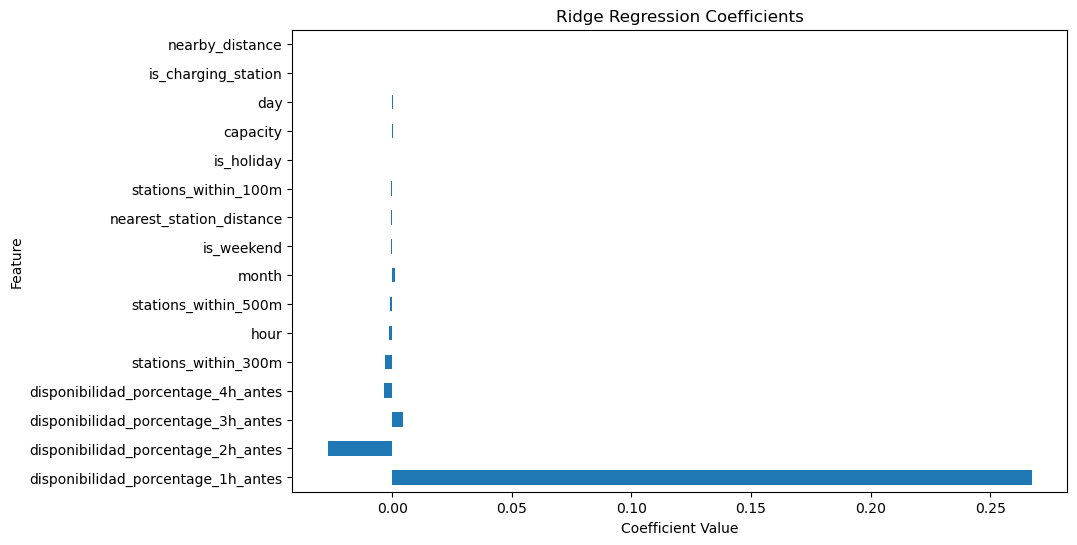

In [202]:

# Get the coefficients
coefficients = ridge_model.coef_

# Create a DataFrame to display the coefficients with feature names
coef_df = pd.DataFrame(coefficients, index=features, columns=['Coefficient'])

# Sort the coefficients by their absolute value (larger absolute values are more important)
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Print or visualize the most important coefficients
print(coef_df)

# Optionally, you can visualize the coefficients
import matplotlib.pyplot as plt
coef_df['Coefficient'].plot(kind='barh', figsize=(10, 6))
plt.title("Ridge Regression Coefficients")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()


R-squared: 0.8232
Mean Squared Error: 0.0133


<Figure size 1000x800 with 0 Axes>

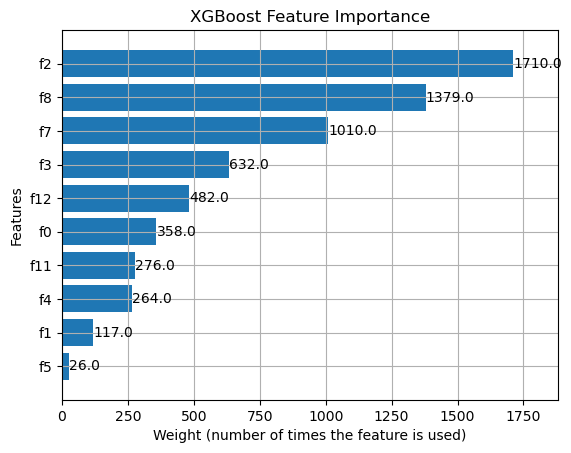

In [107]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Example DataFrame (replace this with your actual DataFrame)
# df_prediction_task = pd.read_csv('your_data.csv')  # If you're reading data from a file

# Select features and target variable
features = ['month', 'day', 'hour', 'capacity', 'is_weekend', 'is_holiday', 'is_charging_station',
            'disponibilidad_porcentage_1h_antes',
           # , 'disponibilidad_porcentage_2h_antes', 
           # 'disponibilidad_porcentage_3h_antes',
           # 'disponibilidad_porcentage_4h_antes', 
            'nearest_station_distance', 'nearby_distance', 'stations_within_100m', 
            'stations_within_300m', 'stations_within_500m']  # Independent variables

target_variable = 'percentage_docks_available'  # Dependent variable

# Prepare the data
df_prediction_task = df_prediction_task.dropna(subset=features + [target_variable])

X = df_prediction_task[features]
y = df_prediction_task[target_variable]

# Standardize the data (important for many ML algorithms, including XGBoost)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize the XGBoost Regressor model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model using R-squared and Mean Squared Error
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Print evaluation metrics
print(f"R-squared: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")

# Plot feature importance with custom column names (feature names should be directly from the model)
plt.figure(figsize=(10, 8))
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=10, 
                    title='XGBoost Feature Importance', height=0.8, 
                    xlabel='Weight (number of times the feature is used)'
                   )
plt.show()


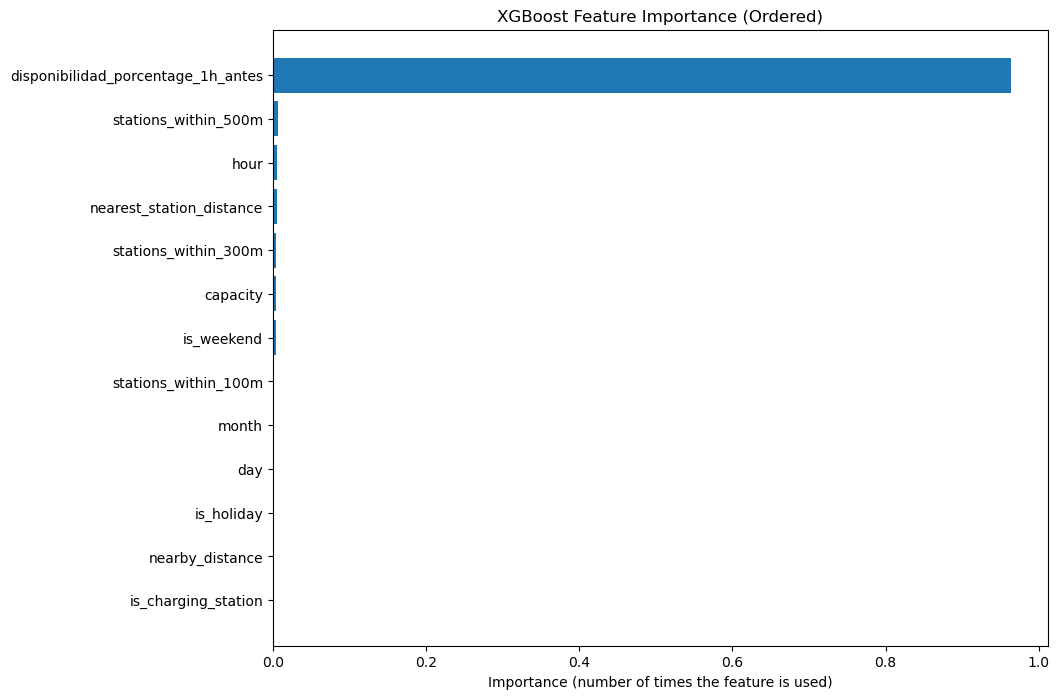

In [109]:
# Extract feature importances
importances = xgb_model.feature_importances_

# Create a DataFrame for importances and corresponding feature names
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Sort the importances according to the order in 'features'
importance_df = importance_df.set_index('Feature').loc[features]

importance_df_mod=importance_df.sort_values(by='Importance', ascending=True)

# Plot feature importance in the same order as 'features'
plt.figure(figsize=(10, 8))

# Plot importance using 'weight' or another importance type
plt.barh(importance_df_mod.index, importance_df_mod['Importance'], align='center')
plt.xlabel('Importance (number of times the feature is used)')
plt.title('XGBoost Feature Importance (Ordered)')
plt.show()

Explained Variance Ratio of each component: [2.55648294e-01 1.72233674e-01 7.86886850e-02 7.49054109e-02
 7.37511795e-02 7.12880147e-02 7.10640053e-02 6.07591367e-02
 5.17312423e-02 2.85712650e-02 2.60366333e-02 2.35563254e-02
 7.73640872e-03 4.02972468e-03 3.10466497e-35 4.20399807e-36]


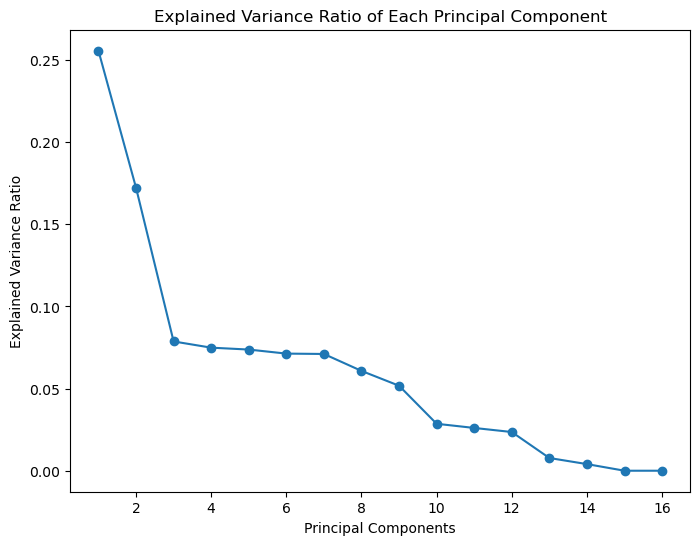

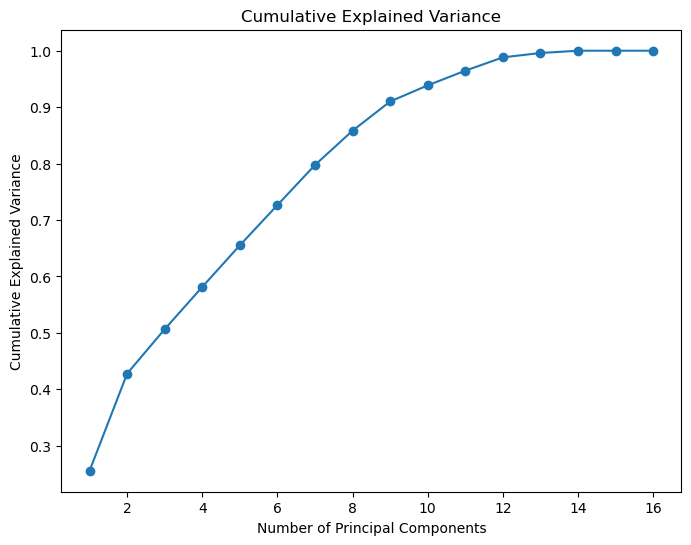

Number of components that explain 95% of the variance: 11


In [99]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Example DataFrame (replace with your actual data)
# df_prediction_task = pd.read_csv('your_data.csv')  # If you're reading data from a file

# Select features for PCA
features = ['month', 'day', 'hour', 'capacity', 'is_weekend', 'is_holiday', 'is_charging_station',
            'disponibilidad_porcentage_1h_antes', 'disponibilidad_porcentage_2h_antes', 
            'disponibilidad_porcentage_3h_antes', 'disponibilidad_porcentage_4h_antes', 
            'nearest_station_distance', 'nearby_distance', 'stations_within_100m', 
            'stations_within_300m', 'stations_within_500m']

# Prepare the data
X = df_prediction_task[features]

# Step 1: Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Step 3: Explained variance ratio to understand how much variance each component captures
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio of each component:", explained_variance)

# Step 4: Plot the explained variance to visualize the importance of each component
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.title('Explained Variance Ratio of Each Principal Component')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.show()

# Step 5: Cumulative Explained Variance (to decide how many components to retain)
cumulative_explained_variance = explained_variance.cumsum()
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# Step 6: Choose the number of components based on cumulative explained variance (e.g., 95%)
n_components = 0
for i, variance in enumerate(cumulative_explained_variance):
    if variance >= 0.95:  # 95% explained variance
        n_components = i + 1
        break

print(f"Number of components that explain 95% of the variance: {n_components}")

# Step 7: Transform data to the selected number of principal components
pca = PCA(n_components=n_components)
X_pca_reduced = pca.fit_transform(X_scaled)

# You can now use X_pca_reduced for modeling (e.g., XGBoost, Ridge regression, etc.)

In [100]:
# Example using XGBoost after PCA
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Split the reduced PCA data
X_train, X_test, y_train, y_test = train_test_split(X_pca_reduced, y, test_size=0.2, random_state=42)

# Train XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R-squared: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")

R-squared: 0.7912
Mean Squared Error: 0.0157
